Investigate how to smooth out the predicted position

### Load data

In [1]:
import sys
sys.path.append('..')
from RingBuffer.RingBuffer import RingBuffer
from sklearn import *
from utils import *
from scipy import signal
from decoder import *

In [2]:
# load previous agg_data

data_file = '../data/agg_buffer_M1_D23.pkl'
agg_buffer = RingBuffer.readPickleStreamFile(data_file)

Total segment read: 21


In [3]:
agg_buffer.shape

(2121, 11)

### Train

-1.936333555173692


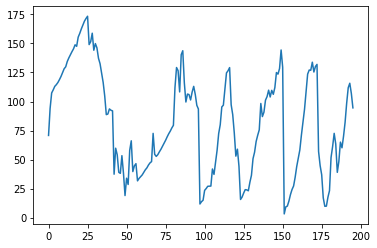

In [4]:
# train
time_bin = 0.1
initial_training_samples = 20
sample2train = int(initial_training_samples/time_bin) # Sampling rate for firing rate is 10Hz, so it is 10s
slidWin = 5

agg_data = agg_buffer[:sample2train,:]
sample2train = 100
spk_train = agg_data[:,:-1] #the last channel is the position data
pos = agg_data[:,-1]

#normalize data and transform data
scaler = preprocessing.StandardScaler()
scaler.fit(spk_train)
norm_spk_train = scaler.transform(spk_train)
spk_scaler = scaler

# make sliding feature
norm_spk_train = makeSlidingWinFeature(norm_spk_train, slidWin)
pos = pos[slidWin-1:]

# scale the position data such that the output is in correct location
pos_scaler = preprocessing.MinMaxScaler(feature_range=(0,200))
pos_scaler.fit(pos.reshape(-1,1))
norm_pos = pos_scaler.transform(pos.reshape(-1,1)).ravel()

polyFeatures = preprocessing.PolynomialFeatures(1).fit(norm_spk_train)
poly_spiketrain = polyFeatures.transform(norm_spk_train)

# train and predict
regressor = svm.SVR(kernel='rbf',C=50,gamma='auto')
regressor.fit(norm_spk_train, norm_pos)

pos_predicted = regressor.predict(norm_spk_train)

# Smooth the output
predicted_smooth = signal.savgol_filter(pos_predicted.ravel(),5,1)

#Evaluate performance
varExplain = model_selection.cross_val_score(regressor,norm_spk_train,norm_pos,cv=5)
print(varExplain.mean())

plt.plot(pos_predicted)

### Predict

(100.0, 500.0)

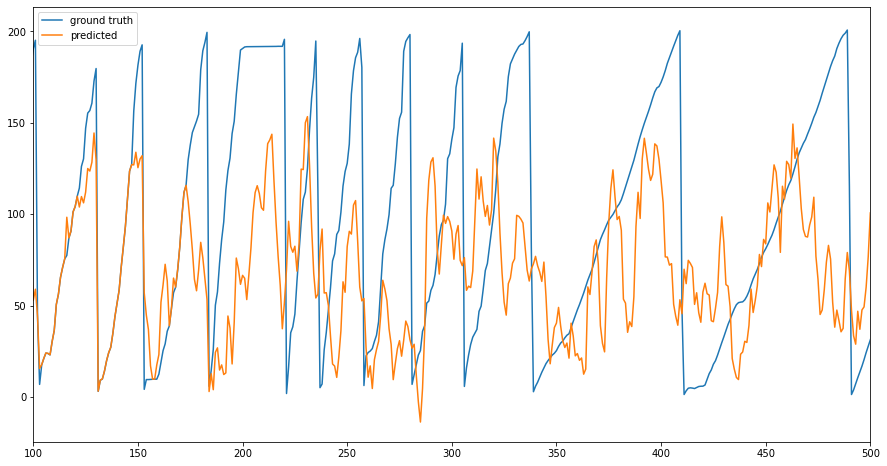

In [5]:
agg_test_data = agg_buffer[initial_training_samples:,:]
spk_train = agg_test_data[:,:-1]

true_pos = agg_test_data[slidWin-1:,-1]
true_pos = pos_scaler.transform(true_pos.reshape(-1,1)).ravel()


#normalize and predict
norm_spk_train = spk_scaler.transform(spk_train)
norm_pos = pos_scaler.transform(pos.reshape(-1,1)).ravel()

norm_spk_train_slid = makeSlidingWinFeature(norm_spk_train,slidWin) #use a sliding window of feature

pos_predicted = regressor.predict(norm_spk_train_slid) #output is an array of position

fig,ax = plt.subplots(1,1,figsize=(15,8))
ax.plot(true_pos, label='ground truth')
ax.plot(pos_predicted,label='predicted')
ax.legend()
ax.set_xlim([100,500])

## Try different ways to smooth the signal
### Method 1: simple exponential smoothing

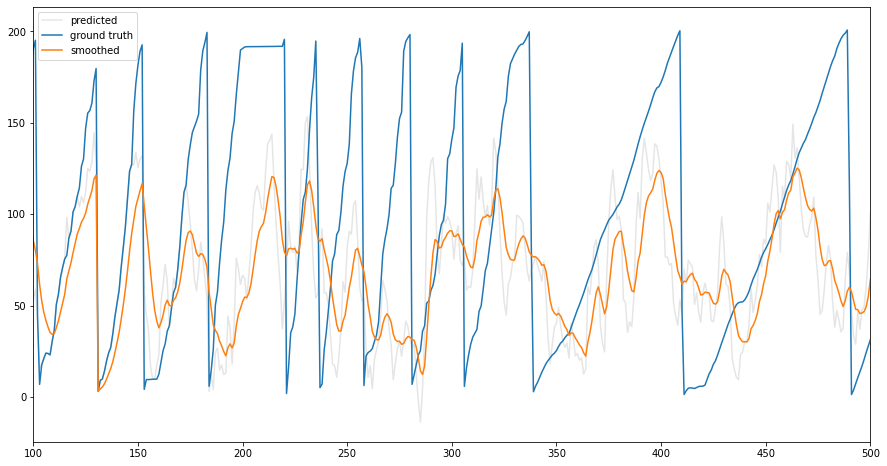

In [6]:

pos_smooth = [pos_predicted[0]]
alpha_smooth = 0.2
for p in pos_predicted[1:]:
    # do not smooth in teleport zone
    if (pos_smooth[-1]-p) > 100:
        pos_smooth.append(p)
    else:
        pos_smooth.append(pos_smooth[-1]*(1-alpha_smooth) + p*alpha_smooth)
pos_smooth = np.array(pos_smooth)
fig,ax = plt.subplots(1,1,figsize=(15,8))
ax.plot(pos_predicted,label='predicted',color='gray',alpha=0.2)
ax.plot(true_pos, label='ground truth')
ax.plot(pos_smooth, label='smoothed')
ax.legend()
ax.set_xlim([100,500])

pos_smooth_ex = pos_smooth

Some observation
- Most useful signal ends when the animal reach the reward zone, maybe it is where active navigation stops?

### Method 2: step movement

1.0000000000000002


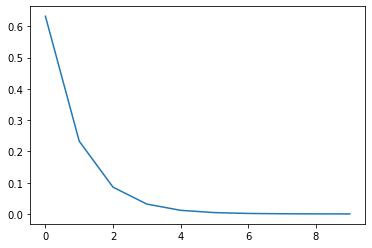

In [7]:
x = np.exp(-np.arange(10))
y = x/sum(x)
print(y.sum())
plt.plot(y)


(100.0, 500.0)

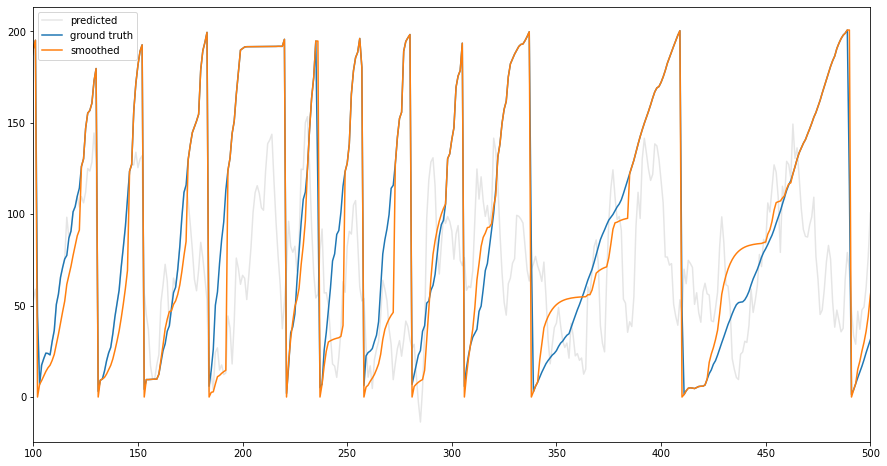

In [8]:
pos_smooth = [pos_predicted[0]]
alpha_smooth = 0.2

# create a profile of acceleration
# accelerate gradually till we reach the target
acc_win = np.exp(-np.arange(5)) # 10 step is 1s
acc_win = acc_win/sum(acc_win)
acc_idx = 0;
target_d = 0
p_true_prev = 0

for i in range(1,len(pos_predicted)):
    # first check where we are, only do decoding in the first half before the reward zone
    # and reset the position when the animal reach the beginning
    # when detected a movement, we apply a force in that direction with damping

    p = pos_predicted[i]
    p_true = true_pos[i]

    # if 65 <i <85:
    #     print(i, p_true, p_true_prev,p_true_prev-p_true)

    if (p_true_prev-p_true) > 100:
        # reset position
        p_next = 0
    elif 10< p_true < 120:
        # p_next = p 
        # # decode zone
        d = p-pos_smooth[-1]
        if d > 0:
            target_d = pos_smooth[-1]+d #set new movement target
            # # print(f'New movement target set {target_d}')
            # acc_idx = 0 # reset if we have a new movement target 
            # p_next = pos_smooth[-1]+ target_d*acc_win[acc_idx] #move forward
            # print(pos_smooth[-1])
            # acc_idx += 1

            p_next = pos_smooth[-1]*(1-alpha_smooth) + alpha_smooth*target_d
        else:
            if pos_smooth[-1] < target_d:
                # continue moving forward we untill we reach the target
                # p_next = pos_smooth[-1]+target_d*acc_win[acc_idx]
                # acc_idx += 1
                p_next = pos_smooth[-1]*(1-alpha_smooth) + alpha_smooth*target_d 
            else:
                p_next = pos_smooth[-1]

    else:
        # movement zone
        p_next = p_true

    p_true_prev = p_true

    pos_smooth.append(p_next)
        

pos_smooth = np.array(pos_smooth)
fig,ax = plt.subplots(1,1,figsize=(15,8))
ax.plot(pos_predicted,label='predicted',color='gray',alpha=0.2)
ax.plot(true_pos, label='ground truth')
ax.plot(pos_smooth, label='smoothed')
ax.legend()
ax.set_xlim([100,500])


In [86]:
pos_smooth = [pos_predicted[0]]
pos_smooth[-1]

158.67416557432594

In [11]:
import pickle
with open('test_smoothed_position.pkl','wb') as f:
    pickle.dump(pos_smooth, f)

In [12]:
pos_smooth.shape

(2097,)